In [1]:
import tensorflow as tf
import collections
import tensorflow_federated as tff

import numpy as np

2026-02-03 09:01:10.290266: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 09:01:10.312097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-03 09:01:10.312121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-03 09:01:10.312136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-03 09:01:10.316649: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow.keras.backend as K
import gc

K.clear_session()  # Clear TF session to free GPU memory
gc.collect()

73

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.14.1


2026-02-03 09:01:15.423465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:01:15.427973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:01:15.429600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)

kidney_dataset = datagen.flow_from_directory(
    '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32,
)

Found 3498 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Label [1. 0.]


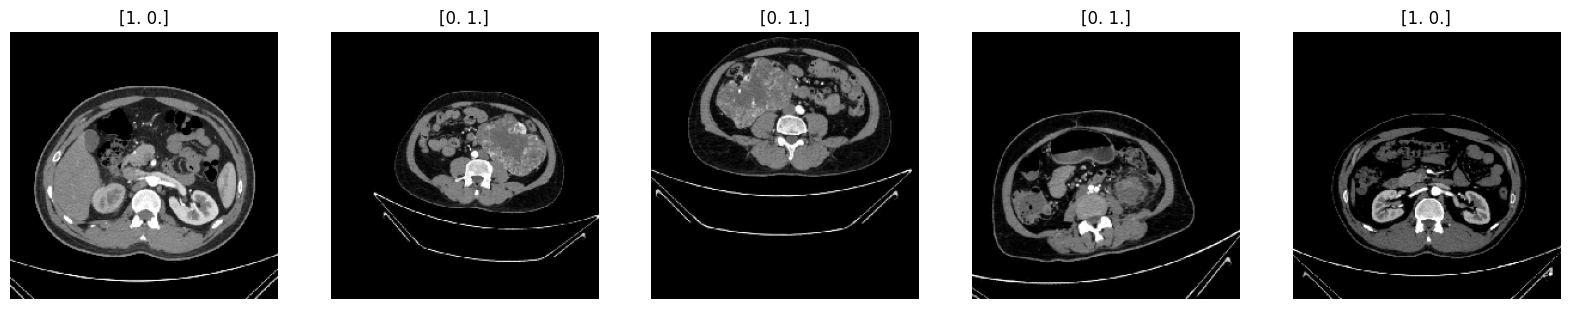

In [5]:
import matplotlib.pyplot as plt
images, labels = next(kidney_dataset)
for i in range(1):
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    print("Min pixel value:", images.min())
    print("Max pixel value:", images.max())
    print("Label", labels[0])

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [6]:
type(kidney_dataset)

keras.src.preprocessing.image.DirectoryIterator

In [7]:
import os

data_dir = '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer'
class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

print(class_labels)

image_paths = []
labels = []
for class_name in class_names:
    path1 = os.path.join(data_dir, class_name)
    print(path1)
    paths = os.listdir(path1)
    for path in paths:
        image_paths.append(os.path.join(path1, path))
        labels.append(class_labels[class_name])

print(image_paths[1])

{'kidney_normal': 0, 'kidney_tumor': 1}
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_tumor
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0403.jpg


In [8]:
NUM_MALICIOUS = 3
FLIP_PROB = 0.4

In [9]:
import os
import random

class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

fake_clients = []

def load_image(path, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def create_client_dataset(image_paths, label, img_size=(224, 224), flip=False, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    images = []
    labels = []
    target_size=(64, 64)
    for i, path in enumerate(image_paths):
        img = load_image(path, img_size)
        img = tf.image.resize(img, target_size)
        images.append(img)
        labels.append(label[i])

    labels = np.array(labels, dtype=np.int32)
    if flip:
        rng = np.random.RandomState(seed)
        num_classes = len(np.unique(labels))
        n = len(labels)

        # randomly choose which samples to flip
        mask = rng.rand(n) < float(flip_prob)

        if mask.sum() > 0:
            rand_targets = rng.randint(0, num_classes, size=n)
            # ensure flipped label != original label
            rand_targets[rand_targets == labels] = (rand_targets[rand_targets == labels] + 1) % num_classes
            labels[mask] = rand_targets[mask]

    print(f"{len(images)}  {len(labels)}   malicious_client={flip}")
    ds = tf.data.Dataset.from_tensor_slices((images, labels.tolist()))
    ds = ds.shuffle(buffer_size=len(images)).batch(8)
    return ds


def prepare_client_dataset(data_dir, num_client, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    image_paths = []
    labels = []

    class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
    class_labels = {name: idx for idx, name in enumerate(class_names)}
    print(class_labels)

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        paths = os.listdir(class_path)
        for path in paths:
            image_paths.append(os.path.join(class_path, path))
            labels.append(class_labels[class_name])

    #image_paths = image_paths[:4000]
    combined = list(zip(image_paths, labels))
    rng = random.Random(seed)
    rng.shuffle(combined)

    combined = combined[:4000]
    image_paths, labels = zip(*combined)

    malicious_clients = []

    all_client_ids = [f"client_{i}" for i in range(num_client)]
    if num_malicious > 0:
        num_malicious = min(num_malicious, num_client)
        malicious_clients = rng.sample(all_client_ids, k=num_malicious)
    print("Malicious clients selected:", malicious_clients)

    clients_datasets = {}
    total_images = len(image_paths)
    for i in range(num_client):
        client_id = "client_{}".format(i)
        start = i * total_images // num_client
        end = ((i + 1) * total_images) // num_client
        print(client_id, start, end)
        do_flip = client_id in malicious_clients
        clients_datasets[client_id] = create_client_dataset(image_paths[start:end], labels[start:end], flip=do_flip, img_size=(224, 224), num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

    return clients_datasets, malicious_clients


client_datasets, fake_clients = prepare_client_dataset(data_dir=data_dir, num_client=10, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

{'kidney_normal': 0, 'kidney_tumor': 1}
Malicious clients selected: ['client_7', 'client_5', 'client_1']
client_0 0 349


2026-02-03 09:01:30.642302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:01:30.643821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:01:30.645326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

349  349   malicious_client=False
client_1 349 699
350  350   malicious_client=True
client_2 699 1049
350  350   malicious_client=False
client_3 1049 1399
350  350   malicious_client=False
client_4 1399 1749
350  350   malicious_client=False
client_5 1749 2098
349  349   malicious_client=True
client_6 2098 2448
350  350   malicious_client=False
client_7 2448 2798
350  350   malicious_client=True
client_8 2798 3148
350  350   malicious_client=False
client_9 3148 3498
350  350   malicious_client=False


In [10]:
fake_clients

['client_7', 'client_5', 'client_1']

In [11]:
client_datasets

{'client_0': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_1': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_2': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_3': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_4': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_5': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_6': <_B

In [12]:
class_labels

{'kidney_normal': 0, 'kidney_tumor': 1}

In [13]:
type(client_datasets['client_0'])

tensorflow.python.data.ops.batch_op._BatchDataset

Client: client_0


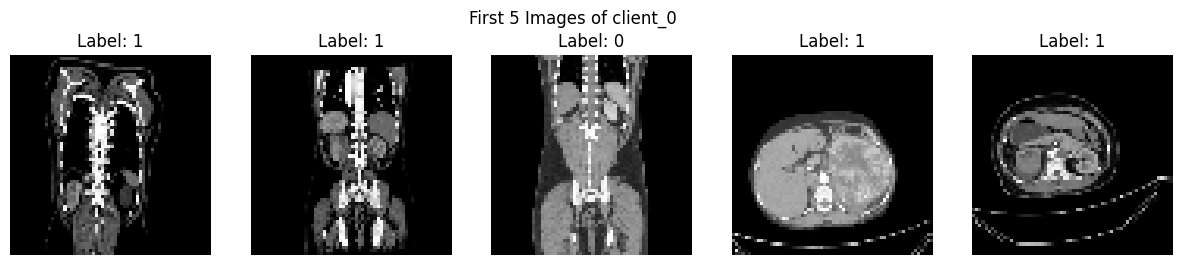

Client: client_1


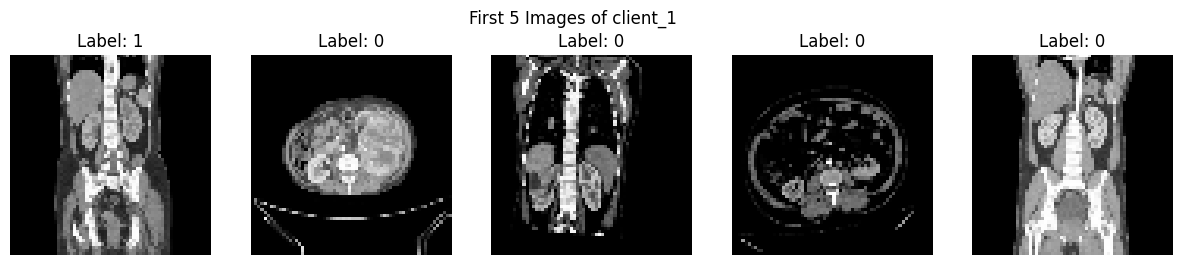

Client: client_2


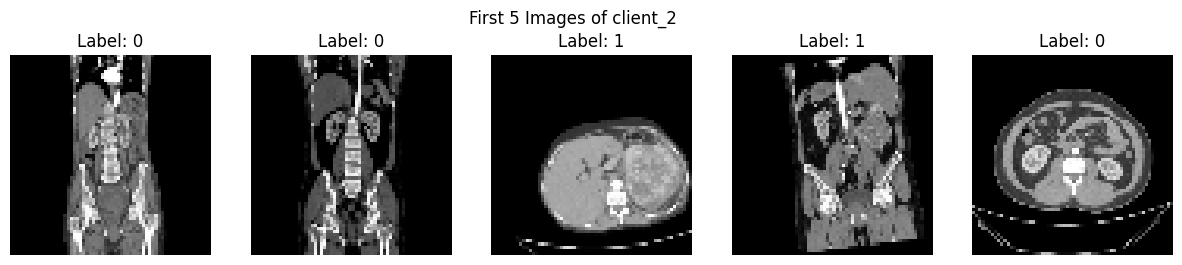

Client: client_3


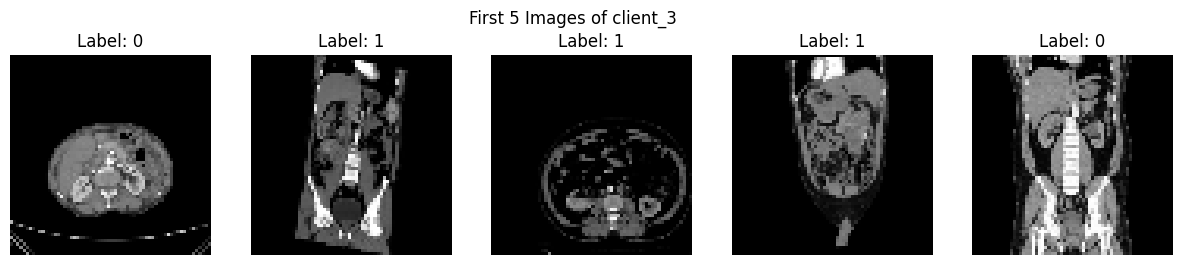

Client: client_4


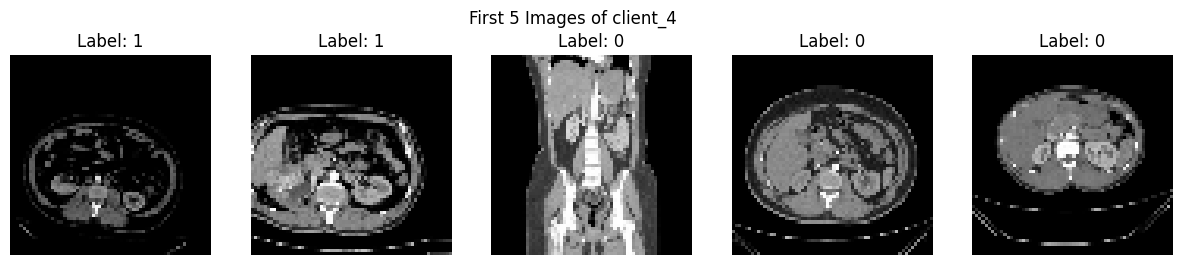

Client: client_5


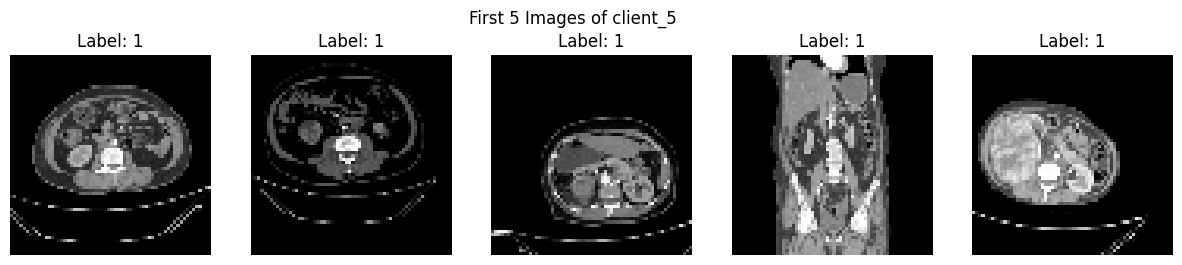

Client: client_6


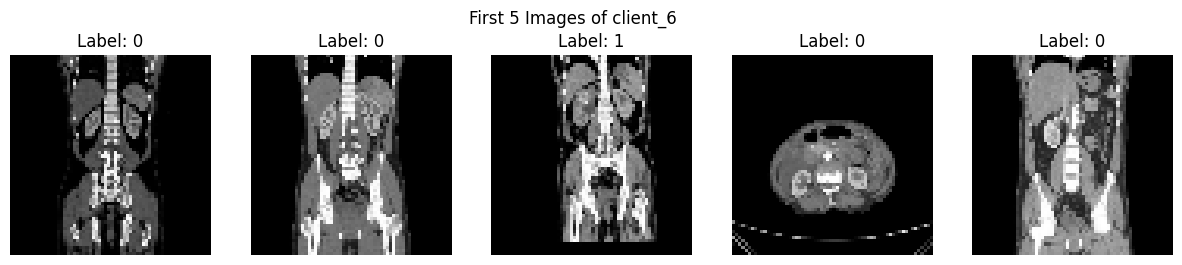

Client: client_7


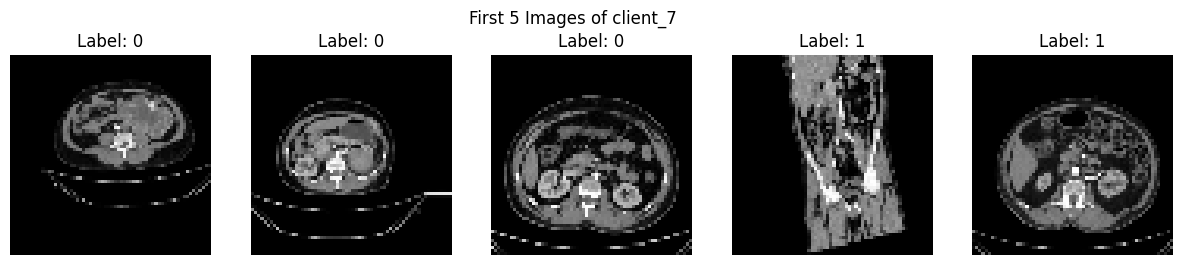

Client: client_8


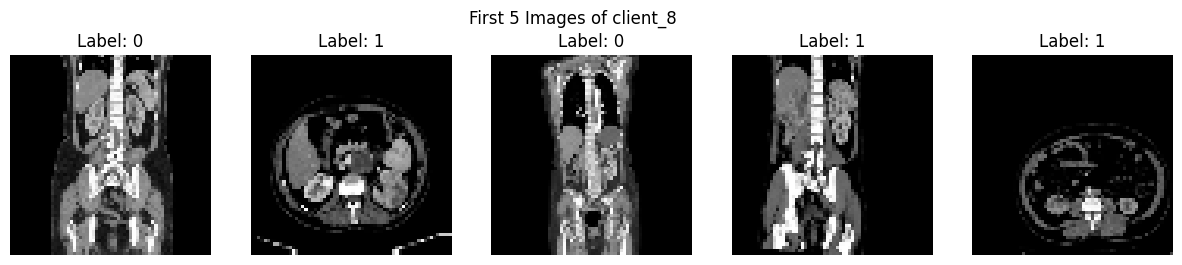

Client: client_9


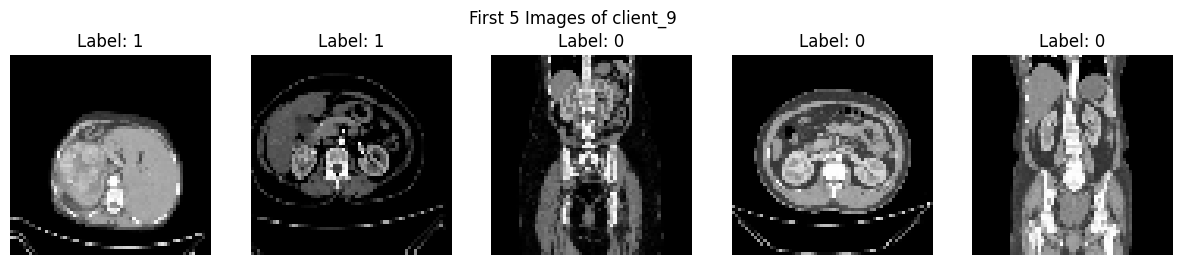

In [14]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, title=None):
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

def print_first_5_images_with_labels(clients_datasets):
    for client_id, dataset in clients_datasets.items():
        print(f"Client: {client_id}")

        images_collected = []
        labels_collected = []
        for batch_images, batch_labels in dataset.take(1):
            images_slice = batch_images[:5]
            labels_slice = batch_labels[:5]
            batch_np_images = images_slice.numpy()
            batch_np_labels = labels_slice.numpy()
            for img, lbl in zip(batch_np_images, batch_np_labels):
                images_collected.append(img)
                labels_collected.append(lbl)

        show_images_with_labels(images_collected, labels_collected, title=f"First 5 Images of {client_id}")


print_first_5_images_with_labels(client_datasets)


In [15]:
for images, labels in client_datasets['client_0'].take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)

(8, 64, 64, 3)
(8,)
tf.Tensor([1 0 1 1 0 1 0 0], shape=(8,), dtype=int32)


In [16]:
## Creating the basic model
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # For 2-class classification
    ])
    return model


In [17]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [18]:
keras_model = create_keras_model()
tff_model = tff.learning.models.functional_model_from_keras(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics_constructor = collections.OrderedDict(
            accuracy = tf.keras.metrics.SparseCategoricalAccuracy
        )
    )

2026-02-03 09:02:04.864423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:02:04.865637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:02:04.866701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
sample_model = create_keras_model()

sample_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for one-hot or multi-class
    metrics=['accuracy']
)

In [20]:
sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [21]:
with tf.device('/GPU:0'):
    sample_model.fit(client_datasets['client_0'], epochs=5, verbose=2)

Epoch 1/5


2026-02-03 09:02:11.867074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2026-02-03 09:02:12.057752: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x737cf1674980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-03 09:02:12.057768: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2026-02-03 09:02:12.060292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-03 09:02:12.123765: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 2s - loss: 0.6776 - accuracy: 0.6046 - 2s/epoch - 35ms/step
Epoch 2/5
44/44 - 0s - loss: 0.4211 - accuracy: 0.8052 - 77ms/epoch - 2ms/step
Epoch 3/5
44/44 - 0s - loss: 0.3775 - accuracy: 0.8309 - 102ms/epoch - 2ms/step
Epoch 4/5
44/44 - 0s - loss: 0.2104 - accuracy: 0.9341 - 184ms/epoch - 4ms/step
Epoch 5/5
44/44 - 0s - loss: 0.0844 - accuracy: 0.9742 - 103ms/epoch - 2ms/step


In [22]:
@tff.tensorflow.computation
def server_init():
    return tff.learning.models.ModelWeights(*tff_model.initial_weights)

In [23]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_eval(server_init, tff.SERVER)

In [24]:
tf_dataset_type = tff.SequenceType(
    tff.types.tensorflow_to_type(tff_model.input_spec)
)

In [25]:
model_weights_type = server_init.type_signature.result

In [26]:
str(tf_dataset_type)

'<float32[?,64,64,3],int32[?]>*'

In [27]:
str(model_weights_type)

'<trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>'

In [28]:
tf.config.run_functions_eagerly(False)

In [29]:
in_client_update_method = []

In [31]:
@tf.function
#@tff.tensorflow.computation
def client_update(model, dataset, initial_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights and the optimizer
  # state.
  client_weights = initial_weights.trainable
  optimizer_state = client_optimizer.initialize(
      tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights)
  )

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    x, y = batch
    with tf.GradientTape() as tape:
      tape.watch(client_weights)
      # Compute a forward pass on the batch of data
      outputs = model.predict_on_batch(
          model_weights=(client_weights, ()), x=x, training=True
      )
      loss = model.loss(output=outputs, label=y)

    # Compute the corresponding gradient
    grads = tape.gradient(loss, client_weights)

    # Apply the gradient using a client optimizer.
    optimizer_state, client_weights = client_optimizer.next(
        optimizer_state, weights=client_weights, gradients=grads
    )

    ##in_client_update_method.append(grads)

  weights = tff.learning.models.ModelWeights(client_weights, non_trainable=())
  in_client_update_method.append(weights)
  return weights

In [32]:
@tff.tensorflow.computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
  return client_update(tff_model, tf_dataset, server_weights, client_optimizer)

In [33]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  del model  # Unused, just take the mean_client_weights.
  return mean_client_weights

In [34]:
@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
  return server_update(tff_model, mean_client_weights)

In [35]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [36]:
captured_client_weights = []

In [37]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):

    server_weights_at_client = tff.federated_broadcast(server_weights)

    client_weights  = tff.federated_map(
        client_update_fn, (federated_dataset, server_weights_at_client)
    )

    mean_client_weights = tff.federated_mean(client_weights)

    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights, client_weights

In [38]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [39]:
str(federated_algorithm.initialize.type_signature)

'( -> <trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>@SERVER)'

In [40]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [41]:
server_weights = server_init()

for r in range(0, 4):
    server_weights, client_updates = next_fn(server_weights, client_datasets_list)
    captured_client_weights.append(client_updates)
    print("Finshed Round {}".format(r))

2026-02-03 09:02:45.246980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:02:45.250789: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2026-02-03 09:02:45.250871: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-02-03 09:02:45.251407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 09:02:45.255733: I tensorflow/compiler/xla/stream_executor/

Finshed Round 0
Finshed Round 1
Finshed Round 2
Finshed Round 3


In [42]:
len(captured_client_weights)

4

In [47]:
len(captured_client_weights[0])

10

In [44]:
server_weights

ModelWeights(trainable=(array([[[[ 1.29885793e-01, -3.22410197e-05, -5.86449504e-02,
           4.16630581e-02,  1.15128085e-01,  8.47995803e-02,
          -1.03047051e-01,  9.48023796e-02,  1.01719081e-01,
           1.04472220e-01,  7.58928508e-02,  1.31807417e-01,
          -4.19878699e-02, -7.42085129e-02,  9.88204777e-02,
           6.38664365e-02,  2.98403054e-02, -1.56111121e-02,
           5.90971410e-02,  8.51380825e-03, -6.08381443e-02,
          -1.04474023e-01, -1.07757531e-01,  1.27121642e-01,
           5.56885675e-02,  3.53943743e-02, -1.20819882e-02,
           8.38287249e-02, -1.73189640e-02,  8.27518553e-02,
          -1.76410545e-02,  1.16325691e-01],
         [-2.30222363e-02, -3.13718105e-03,  3.49983461e-02,
          -1.81040503e-02, -1.28746092e-01, -9.09790397e-02,
          -1.10669672e-01, -4.17982116e-02,  8.06778520e-02,
          -1.17535159e-01, -1.14217520e-01, -7.73546845e-02,
           3.83507013e-02,  9.88106616e-03, -8.82373750e-02,
           1.075

In [ ]:
len(in_client_update_method)

In [ ]:
len(in_client_update_method[0][0])

In [ ]:
in_client_update_method[0][0]

In [ ]:
server_weights

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0),
    #model_aggregator= CollectClientUpdateds()
)

In [ ]:
print(training_process.initialize.type_signature.formatted_representation())

In [ ]:
print(training_process.next.type_signature)

In [ ]:
train_state = training_process.initialize()

In [ ]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [ ]:
#import importlib
#serialization_utils = importlib.import_module('tensorflow_federated.python.program.serialization_utils')
#print(serialization_utils._MAX_SERIALIZED_DATASET_SIZE)
##serialization_utils._MAX_SERIALIZED_DATASET_SIZE = 1073741824

In [ ]:
print(tff.__file__)

In [ ]:
print(training_process.next)

In [ ]:
train_accuracies = []
train_losses = []
train_state_data = []
metrics_data = []
NUM_ROUNDS = 30

for round_num in range(1, NUM_ROUNDS):
  result = training_process.next(train_state, client_datasets_list)
  train_state = result.state
  train_state_data.append(train_state)
  metrics = result.metrics
  metrics_data.append(metrics)
  print('round {:2d}, metrics={}'.format(round_num, metrics))
  try:
        acc = metrics['client_work']['train']['sparse_categorical_accuracy']
        loss = metrics['client_work']['train']['loss']
  except KeyError:
        print(f"Available metric keys at round {round_num}: {metrics.keys()}")
        acc, loss = None, None

  train_accuracies.append(acc)
  train_losses.append(loss)
  print(f"Round {round_num}: accuracy={acc:.4f}, loss={loss:.4f}")

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_accuracies, color='green', marker='o')
plt.title('Federated Training Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_losses, color='red', marker='o')
plt.title('Federated Training Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
print(result)

In [ ]:
len(train_state_data)

In [ ]:
train_state_data[0]

In [ ]:
train_state_data[0][0][0]

In [ ]:
metrics

In [ ]:
x = train_state_data[0][0][0]
(rows, cols) = (len(x), len(x[0]))
print(rows, cols)

In [ ]:
def list_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        lst = lst[0] if len(lst) > 0 else []
    return tuple(shape)

list_shape(train_state_data[0][0][0])

In [ ]:
metrics_data[0]['client_work']